# iSDA soil data

* **Products used:** 
[iSDA Soil](https://aws.amazon.com/marketplace/pp/prodview-3bfpv6jsl4tqk?sr=0-4&ref_=beagle&applicationId=AWSMPContessa)


## Background
[iSDAsoil](https://www.isda-africa.com/isdasoil/) is an open access soils data resource for the African continent. Soils data can be useful for a range of applications including land suitability mapping for agriculture, soil amelioration planning (e.g. liming to address acidic soils or fertiliser to address fertility constraints), and for construction/ infrastructure planning.

## Description
This notebook demonstrates how to integrate this data with DE Africa products and workflows. For technical information on iSDAsoil, see [Miller et al. 2021](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001441). Some of the code in this notebook has been adapted from the [iSDA-Africa GitHub](https://github.com/iSDA-Africa).

1. Load iSDA data
2. Visualise iSDA against DE Africa products

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Note that we are loading a module called `load_isda()` for this notebook which takes a little while to load.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio as rio
from pyproj import Transformer
import matplotlib.pyplot as plt
import os
import numpy as np

from urllib.parse import urlparse
import boto3
from pystac import stac_io, Catalog
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.load_isda import load_isda

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='iSDA-soil')

## iSDA variables

iSDA offers numerous soil variables shown in the table below. Many of the variables have four layers: mean and standard deviation at 0-20cm and 20-5cm depth. We will see through the notebook that we can bring in each variable with the Access Names e.g. 'bedrock_depth'.

Some variables are indexed in Digital Earth Africa, and others can be brought in directly.

|Variable|Access Name|Layers|
|---|---|---|
|Aluminium, extractable|aluminium_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|
|Depth to bedrock|bedrock_depth|0-200cm depth, predicted mean and standard deviation|
|Bulk density, <2mm fraction|bulk_density|0-20cm and 20-50cm, predicted mean and standard deviation|
|Calcium, extractable|calcium_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|
|Carbon, organic|carbon_organic|0-20cm and 20-50cm, predicted mean and standard deviation|
|Carbon, total|carbon_total|0-20cm and 20-50cm, predicted mean and standard deviation|
|Effective Cation Exchange Capacity|cation_exchange_capacity|0-20cm and 20-50cm, predicted mean and standard deviation|
|Clay content|clay_content|0-20 cm and 20-50 cm, predicted mean and standard deviation|
|Fertility Capability Classification|fcc| Single classification layer|
|Iron, extractable|iron_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|
|Magnesium, extractable|magnesium_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|
|Nitrogen, total|nitrogen_total|0-20cm and 20-50cm, predicted mean and standard deviation|
|pH|ph|0-20cm and 20-50cm, predicted mean and standard deviation|
|Phosphorus, extractable|phosphorous_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|
|Potassium, extractable|potassium_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|
|Sand content|sand_content|0-20cm and 20-50cm, predicted mean and standard deviation|
|Silt content|silt_content|0-20cm and 20-50cm, predicted mean and standard deviation|
|Stone content|stone_content|Coarse fragments predicted at 0-20cm depth|
|Sulphur, extractable|sulphur_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|
|USDA Texture Class|texture_class|0-20cm and 20-50cm depth, predicted mean|
|Zinc, extractable|zinc_extractable|0-20cm and 20-50cm, predicted mean and standard deviation|

## Indexed soil data

There are six iSDA soil datasets indexed by Digital Earth Africa and available for direct loading.

In [3]:
# List iSDA products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    'soil').fillna(
        False)][display_columns].set_index('name')

description
name                                                                      
isda_soil_bedrock_depth  Soil bedrock depth predictions made by iSDA Af...
isda_soil_bulk_density   Soil bulk density predictions made by iSDA Africa
isda_soil_carbon_total   Soil total carbon predictions made by iSDA Africa
isda_soil_clay_content   Soil clay content predictions made by iSDA Africa
isda_soil_sand_content   Soil sand content predictions made by iSDA Africa
isda_soil_silt_content   Soil silt content predictions made by iSDA Africa

### List measurements

Many of the soil products have measurements for two depths: 0-20cm and 20-50cm. They also have mean estimates plus standard deviations, as shown below for total soil carbon.

In [4]:
product_name = 'isda_soil_carbon_total'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype units  nodata        aliases
measurement                                                   
mean_0_20      mean_0_20  float32  g/kg     NaN    [MEAN_0_20]
mean_20_50    mean_20_50  float32  g/kg     NaN   [MEAN_20_50]
stdev_0_20    stdev_0_20  float32  g/kg     NaN   [STDEV_0_20]
stdev_20_50  stdev_20_50  float32  g/kg     NaN  [STDEV_20_50]

### Define parameters

Let's define some parameters for loading the Fertility Capability Classification in a coastal area near Cape Town, South Africa. We can see in the table above that we can access this variable with `fcc'. 

In [5]:
lat = -32.9
lon = 18.7
buffer = 0.5

display_map((lon - buffer, lon + buffer), (lat - buffer, lat + buffer))

## Load iSDA soil data using `dc.load()`

Now that we know what products and measurements are available, we can load data from the datacube using `dc.load`.

In [6]:
# load data
ds = dc.load(product="isda_soil_carbon_total",
             measurements=['mean_0_20', 'mean_20_50', 'stdev_0_20', 'stdev_20_50'],
             x=(lon - buffer, lon + buffer),
             y=(lat - buffer, lat + buffer)
             )

ds

<xarray.Dataset>
Dimensions:      (time: 1, y: 4421, x: 3712)
Coordinates:
  * time         (time) datetime64[ns] 2009-01-01
  * y            (y) float64 -3.816e+06 -3.816e+06 ... -3.948e+06 -3.949e+06
  * x            (x) float64 2.026e+06 2.026e+06 ... 2.137e+06 2.137e+06
    spatial_ref  int32 3857
Data variables:
    mean_0_20    (time, y, x) float32 nan nan nan nan ... 28.0 29.0 28.0 28.0
    mean_20_50   (time, y, x) float32 nan nan nan nan ... 26.0 26.0 27.0 25.0
    stdev_0_20   (time, y, x) float32 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
    stdev_20_50  (time, y, x) float32 nan nan nan nan nan ... 3.0 3.0 3.0 3.0
Attributes:
    crs:           EPSG:3857
    grid_mapping:  spatial_ref

## <span style="color:red">**Transformation!**</span> 

Importantly, much of the iSDA data needs to be transformed before it's applied. For indexed datasets, we can get conversion metadata associated with each variable in the `flags_definition`. This is performed for our selected variable below.

In [7]:
ds.mean_0_20.flags_definition

{'back-transformation': 'expm1(x/10)'}

In [8]:
ds = np.expm1(ds/10)

### Plot soil information

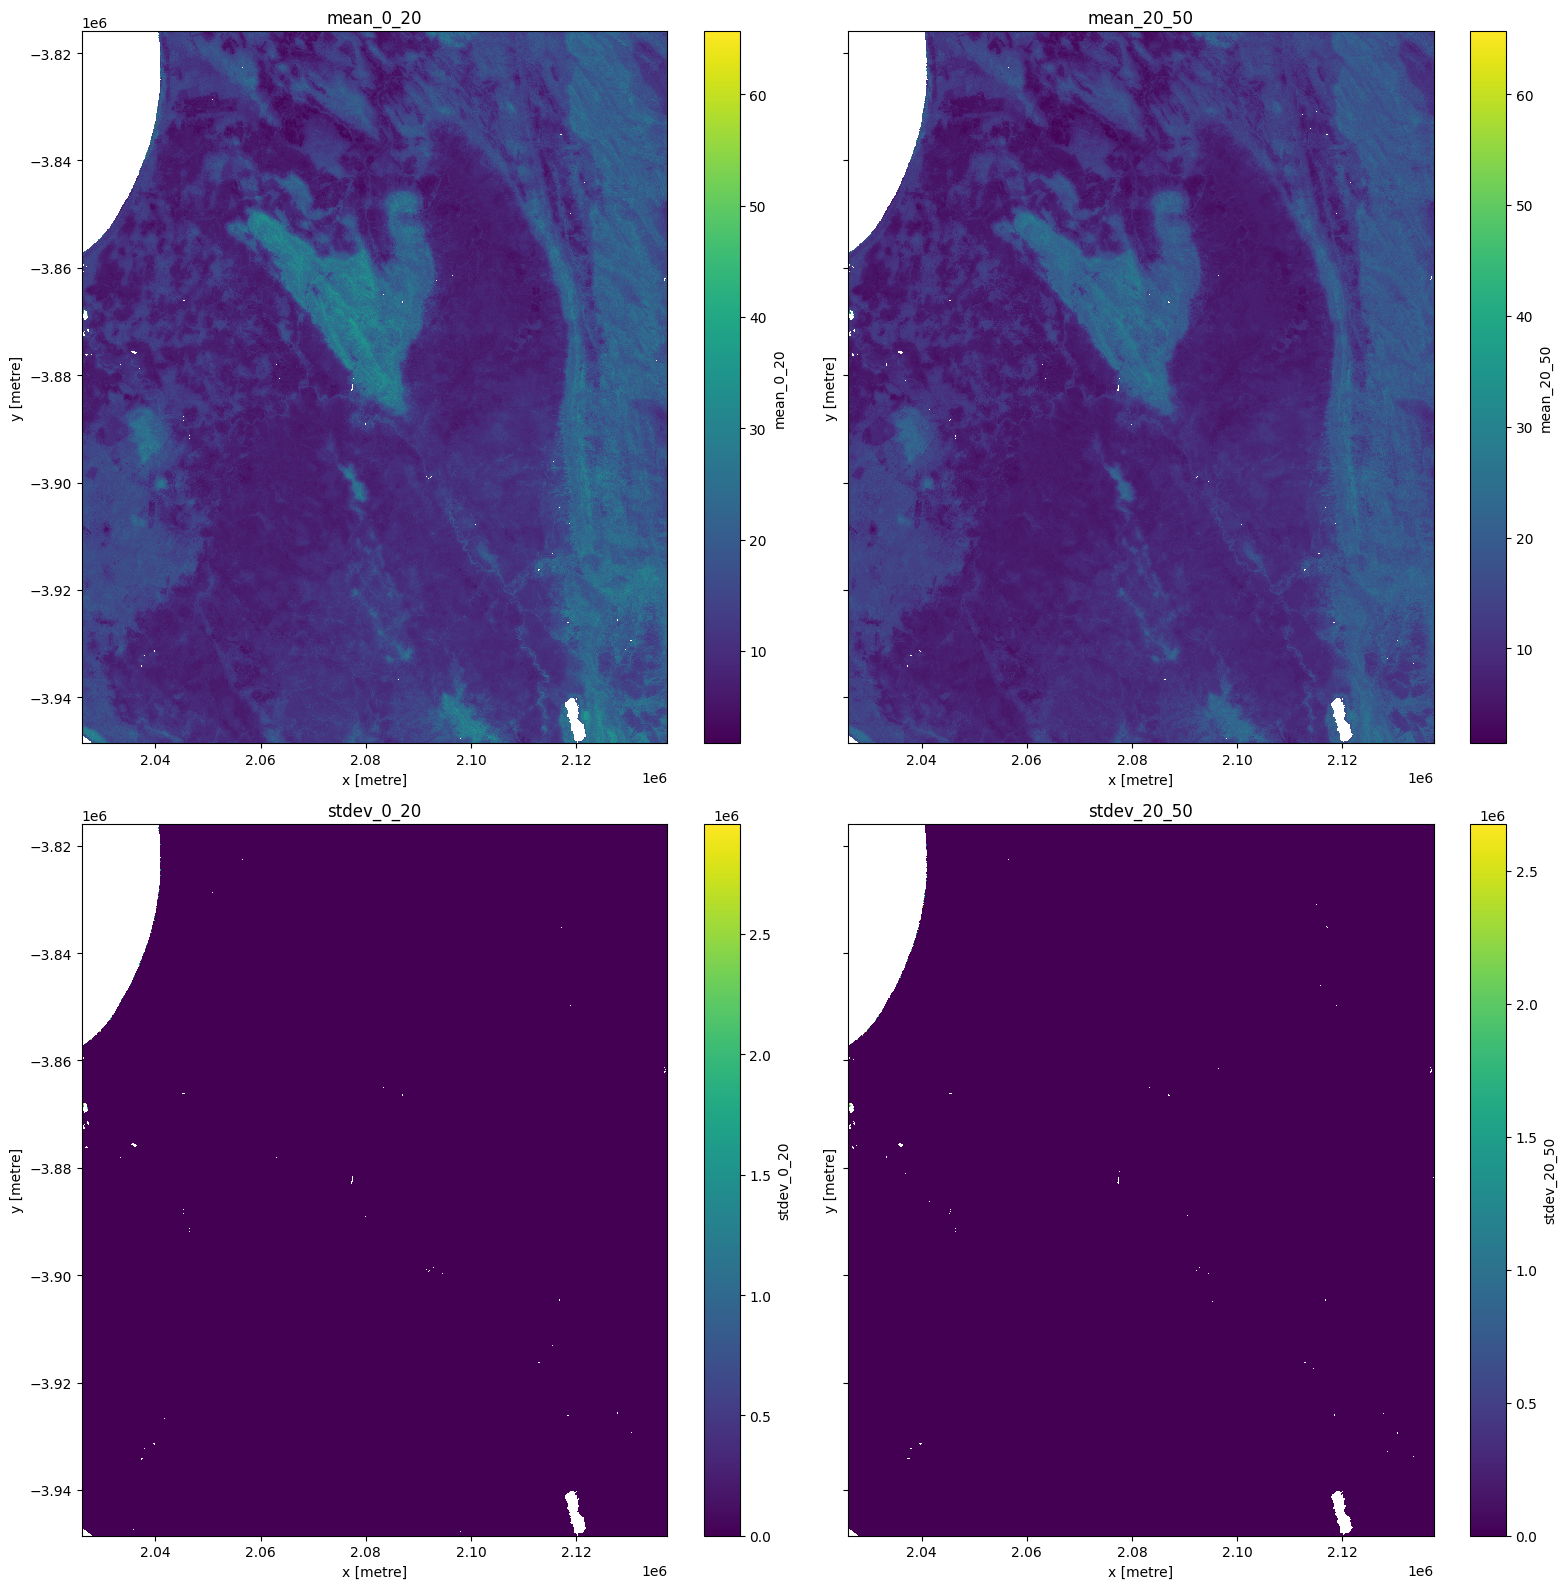

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
ds[list(ds.keys())[0]].plot(ax=ax[0, 0])
ds[list(ds.keys())[1]].plot(ax=ax[0, 1])
ds[list(ds.keys())[2]].plot(ax=ax[1, 0])
ds[list(ds.keys())[3]].plot(ax=ax[1, 1])
ax[0, 0].set_title(list(ds.keys())[0])
ax[0, 1].set_title(list(ds.keys())[1])
ax[1, 0].set_title(list(ds.keys())[2])
ax[1, 1].set_title(list(ds.keys())[3])
plt.tight_layout();

# Load iSDA data from source

As we saw in the introductory sections of this notebook, there are six iSDA variables indexed by Digital Earth Africa for loading using `dc.load`. 

Other iSDA datasets can be loaded from source. Though there are some complexities with this method of loading as metadata must be accessed to identify transformations, and we must also allocate a spatial projection.

## Link to iSDA metadata

There are a few complexities associated with the iSDA data, such as back-transformations / conversions that we will see later in the notebook. We need to link to metadata so we can explore these.

The cell below provides a link to the necessary metadata.

In [10]:
#this function allows us to directly query the data on s3
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme == 's3':
        bucket = parsed.netloc
        key = parsed.path[1:]
        s3 = boto3.resource('s3')
        obj = s3.Object(bucket, key)
        return obj.get()['Body'].read().decode('utf-8')
    else:
        return stac_io.default_read_text_method(uri)
    
stac_io.read_text_method = my_read_method

catalog = Catalog.from_file("https://isdasoil.s3.amazonaws.com/catalog.json")

assets = {}

for root, catalogs, items in catalog.walk():
    for item in items:
        str(f"Type: {item.get_parent().title}")
        # save all items to a dictionary as we go along
        assets[item.id] = item
        for asset in item.assets.values():
            if asset.roles == ['data']:
                str(f"Title: {asset.title}")
                str(f"Description: {asset.description}")
                str(f"URL: {asset.href}")
                str("------------")

## Load Fertility Capability Classification

The cell below uses the `load_isda()` function to bring in Fertility Capability Classification for the area defined above. 

We can see below that the function returns a variable called `band_data` as `float32`.

In [11]:
var = "fcc"

ds = load_isda(var, (lat-buffer, lat + buffer), (lon-buffer, lon + buffer))
ds

<xarray.Dataset>
Dimensions:      (x: 3712, y: 4420)
Coordinates:
    band         int64 1
  * x            (x) float64 2.026e+06 2.026e+06 ... 2.137e+06 2.137e+06
  * y            (y) float64 -3.816e+06 -3.816e+06 ... -3.948e+06 -3.949e+06
    spatial_ref  int64 0
Data variables:
    band_data    (y, x) float32 ...

## <span style="color:red">**Transformation!**</span> 

Importantly, much of the iSDA data needs to be transformed before it's applied. We can use the object we stored called `assets` to get conversion metadata associated with each variable. This is performed for our selected variable below.

We can see that the `fcc` variable returns a conversion value of `%3000`.

In [12]:
conversion = assets[var].extra_fields["back-transformation"]
conversion

'%3000'

Below, the transformation is made and a new band added to the dataset. The values are converted to integers for easier interpretation and plotting.

In [13]:
ds = ds.assign(fcc = (ds["band_data"]%3000).fillna(2535).astype('int16'))

Labels can also be drawn from the metadata. Below, classes of fertility are mapped to their respective integers for better plotting outputs.

In [14]:
fcc_labels = pd.read_csv(assets['fcc'].assets["metadata"].href, index_col=0)

mappings = {val:fcc_labels.loc[int(val),"Description"] for val in np.unique(ds.fcc.astype('int16'))}

### Plot Fertility Capability Classification

We can now plot the `fcc` data with labels.

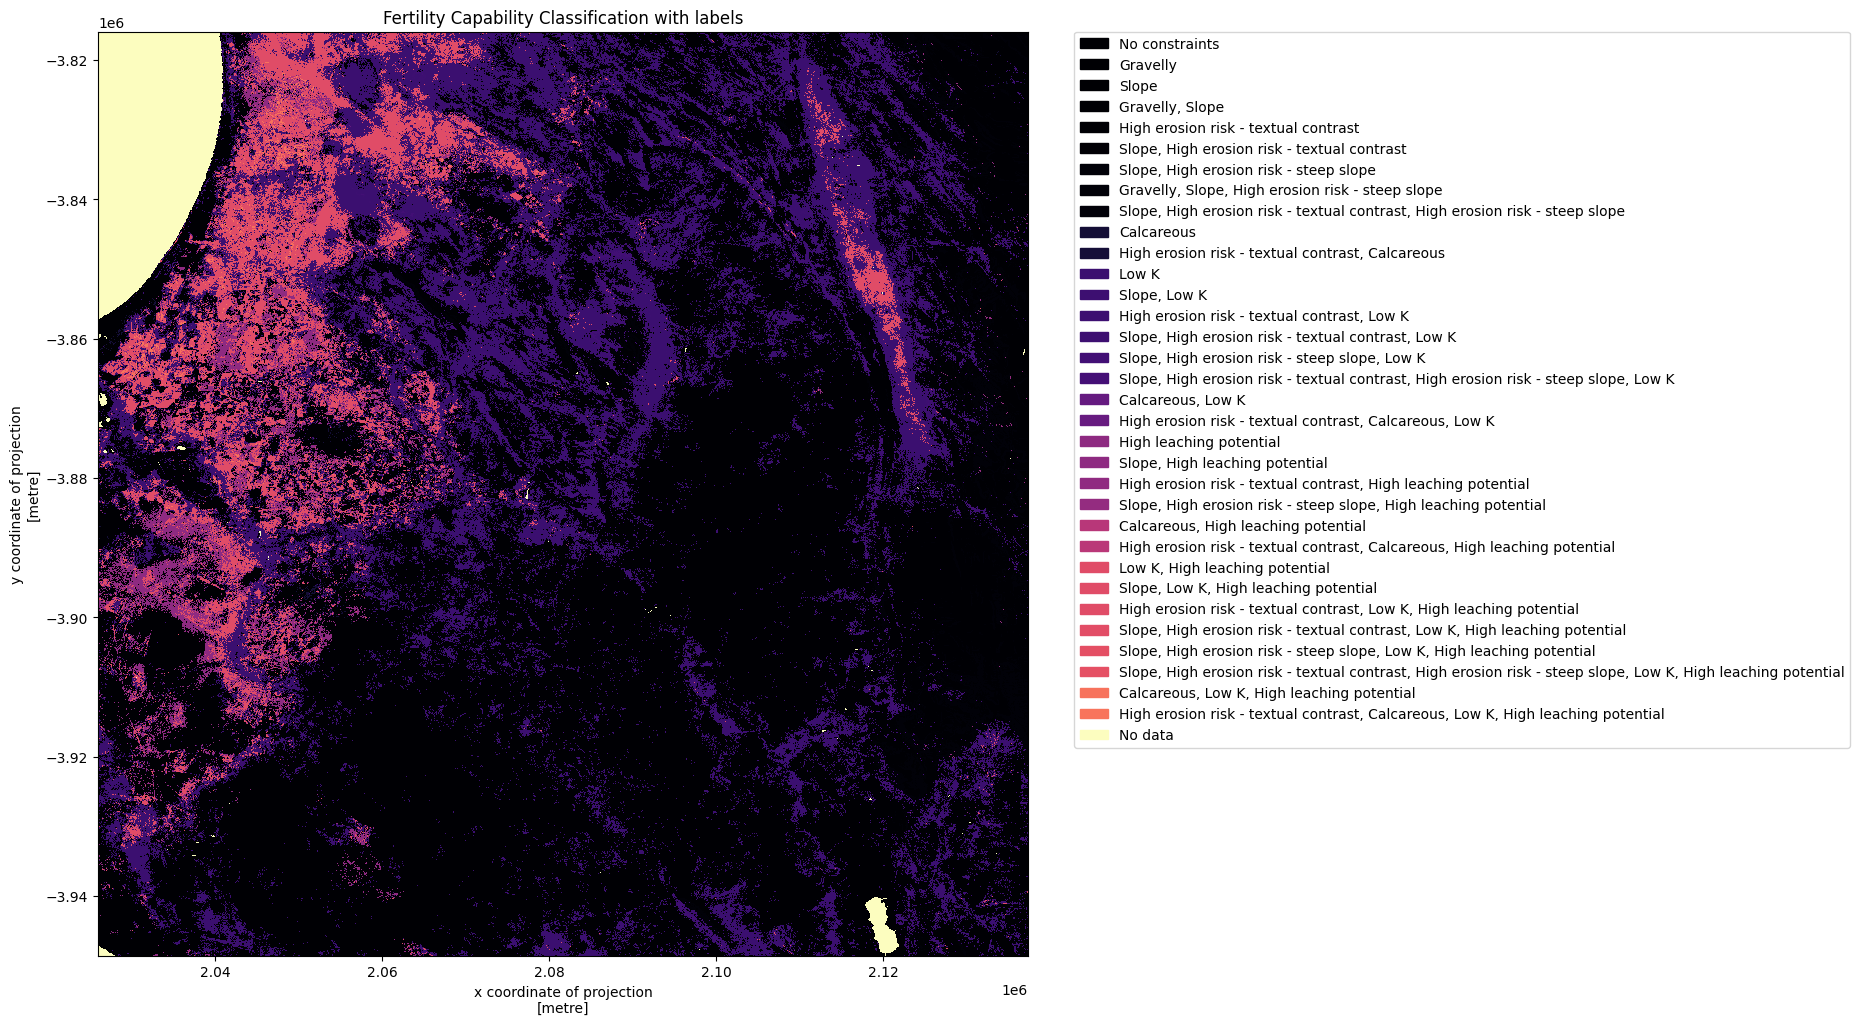

In [15]:
plt.figure(figsize=(12,12), dpi= 100)
im = ds.fcc.plot(cmap="magma", add_colorbar=False)
colors = [ im.cmap(im.norm(value)) for value in np.unique(ds.fcc)]
patches = [mpatches.Patch(color=colors[idx], label=str(mappings[val])) for idx, val in enumerate(np.unique(ds.fcc))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title("Fertility Capability Classification with labels")
plt.show()

## Clay in Okavango Delta

Now we'll inspect soil clay content in the Okavango Delta, Botswana. 

### New parameters

New parameters for data loading are defined in the cell below. The `var` object is taken from the relevant Access Name shown at the beginning of this notebook.

In [16]:
var = 'clay_content'

lat = -19.6
lon = 22.6
buffer = 0.5

display_map((lon - buffer, lon + buffer), (lat - buffer, lat + buffer))

Use the `load_isda()` function to bring in clay content data.

In [17]:
ds = load_isda(var, (lat-buffer, lat + buffer), (lon-buffer, lon + buffer))
ds

/usr/local/lib/python3.8/dist-packages/rioxarray/_io.py:314: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  out = riods.read(band_key, window=window, masked=self.masked)


<xarray.Dataset>
Dimensions:                                             (x: 3711, y: 3940)
Coordinates:
  * x                                                   (x) float64 2.46e+06 ...
  * y                                                   (y) float64 -2.167e+0...
    spatial_ref                                         int64 0
    band                                                <U9 'band_data'
Data variables:
    Clay content, predicted mean at 0-20 cm depth       (y, x) float32 13.0 ....
    Clay content, predicted mean at 20-50 cm depth      (y, x) float32 13.0 ....
    Clay content, standard deviation at 0-20 cm depth   (y, x) float32 2.0 .....
    Clay content, standard deviation at 20-50 cm depth  (y, x) float32 2.0 .....

## <span style="color:red">**Transformation!**</span> 

Check if and how the data needs to be transformed. In this case, there is no transformation and the data can be interpreted as %, so we can proceed.

In [18]:
conversion = assets[var].extra_fields["back-transformation"]
conversion

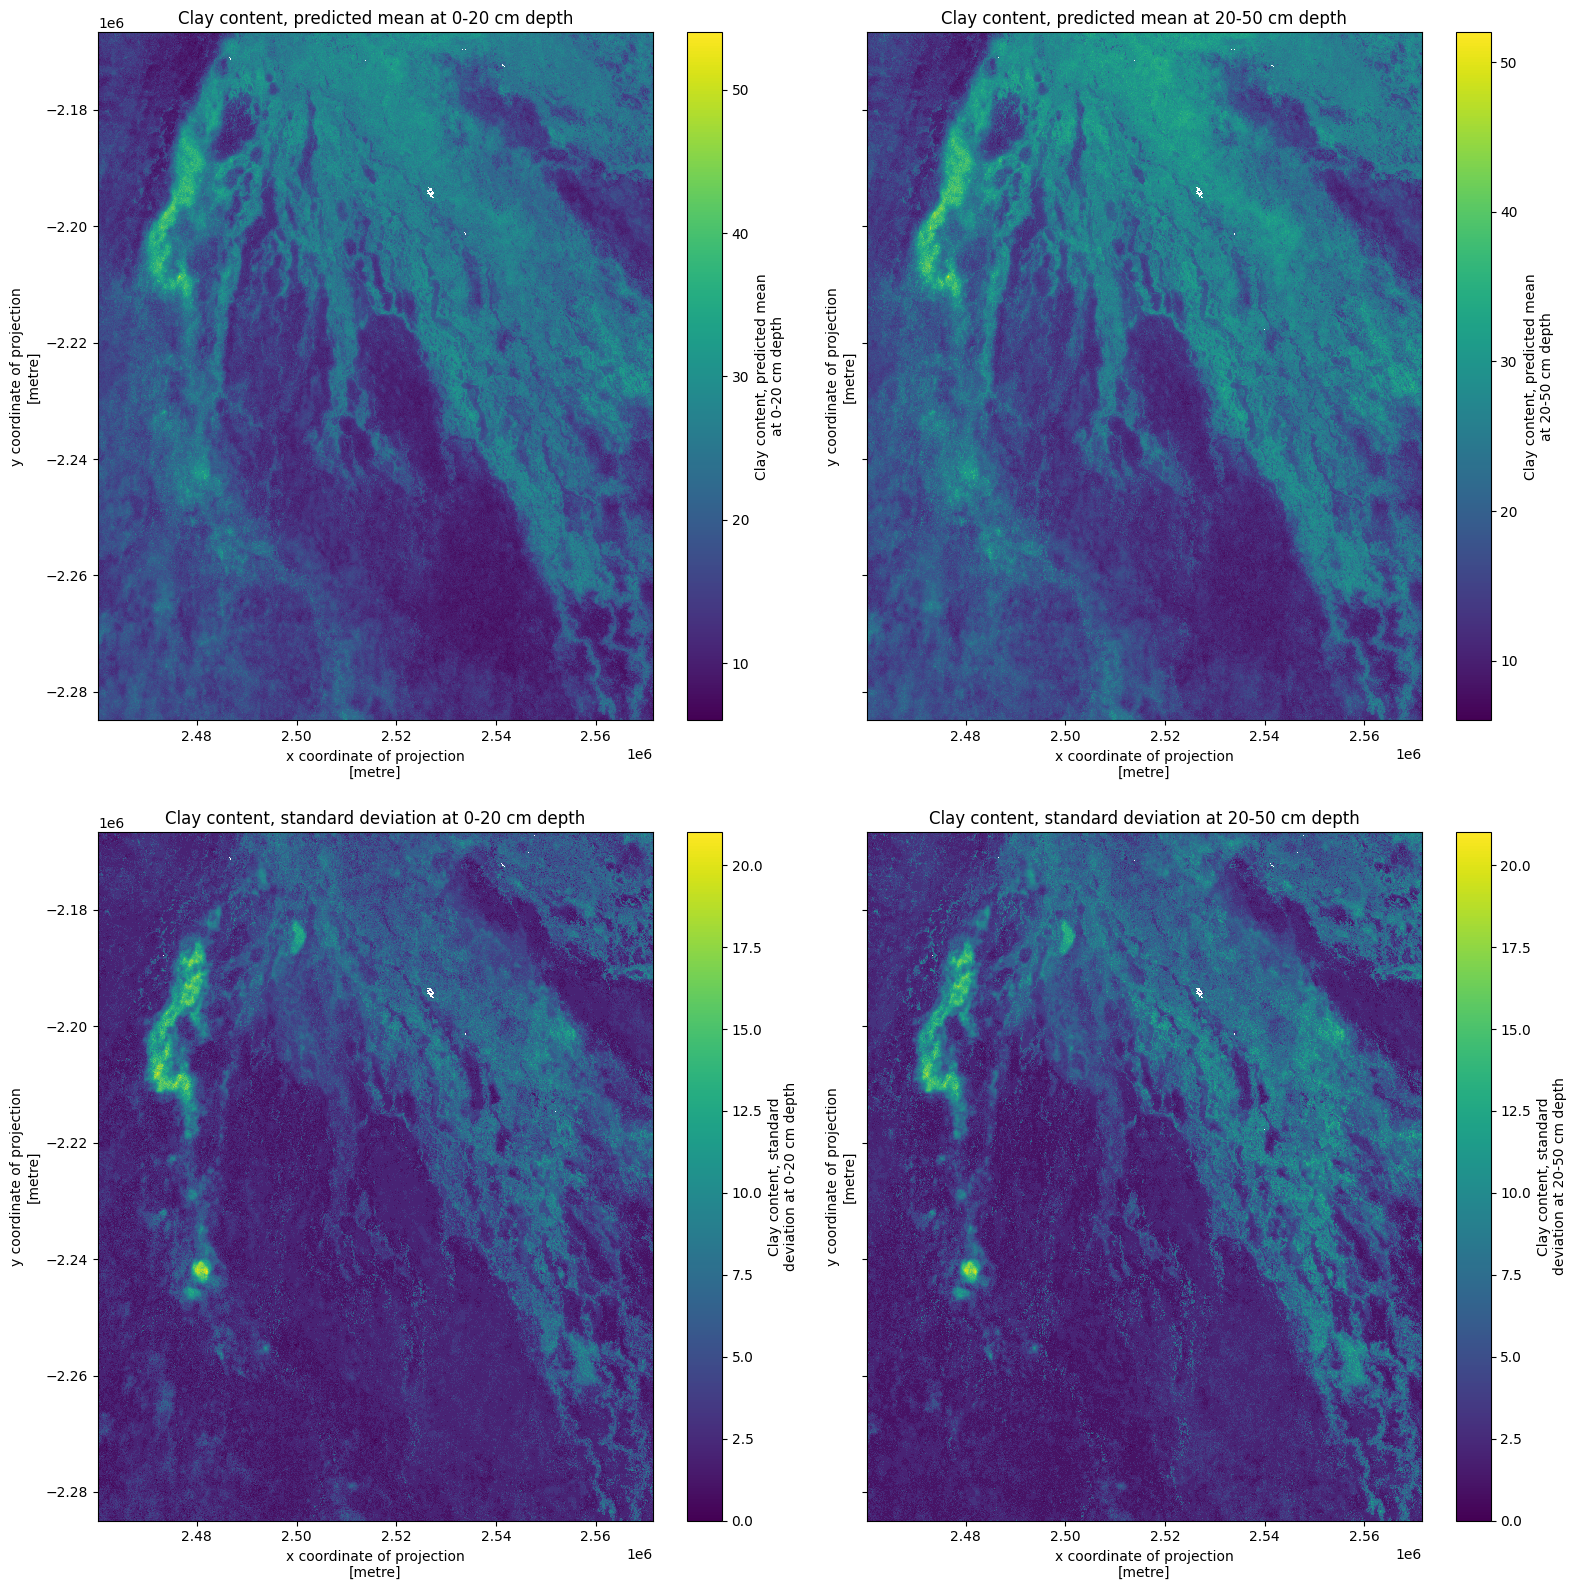

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
ds[list(ds.keys())[0]].plot(ax=ax[0, 0])
ds[list(ds.keys())[1]].plot(ax=ax[0, 1])
ds[list(ds.keys())[2]].plot(ax=ax[1, 0])
ds[list(ds.keys())[3]].plot(ax=ax[1, 1])
ax[0, 0].set_title(list(ds.keys())[0])
ax[0, 1].set_title(list(ds.keys())[1])
ax[1, 0].set_title(list(ds.keys())[2])
ax[1, 1].set_title(list(ds.keys())[3])
plt.tight_layout();

## Soil pH

Finally, we'll inspect soil pH for the same Okavango Delta region. 

The `lat` and `lon` definitions will remain constant, just the `var` is changed below, as per the table with Access Names at the beginning of the notebook.

In [20]:
var = 'ph'

In [21]:
ds = load_isda(var, (lat-buffer, lat + buffer), (lon-buffer, lon + buffer))
ds

/usr/local/lib/python3.8/dist-packages/rioxarray/_io.py:314: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  out = riods.read(band_key, window=window, masked=self.masked)


<xarray.Dataset>
Dimensions:                                   (x: 3711, y: 3940)
Coordinates:
  * x                                         (x) float64 2.46e+06 ... 2.571e+06
  * y                                         (y) float64 -2.167e+06 ... -2.2...
    spatial_ref                               int64 0
    band                                      <U9 'band_data'
Data variables:
    pH, predicted mean at 0-20 cm depth       (y, x) float32 65.0 65.0 ... 66.0
    pH, predicted mean at 20-50 cm depth      (y, x) float32 66.0 65.0 ... 67.0
    pH, standard deviation at 0-20 cm depth   (y, x) float32 1.0 1.0 ... 2.0 1.0
    pH, standard deviation at 20-50 cm depth  (y, x) float32 1.0 1.0 ... 1.0 1.0

## <span style="color:red">**Transformation!**</span> 

Check if and how the data needs to be transformed. 

In [22]:
conversion = assets[var].extra_fields["back-transformation"]
conversion

'x/10'

We need to divide by 10, which is executed below.

Inspecting the xarray.Dataset above, from when we called `ds`, also indicates the need for transformation. We would expect pH values to range between 0 and 14, but we can see values around 60-70. The range below, after dividing by 10, looks better.

In [23]:
ds = ds / 10
ds

<xarray.Dataset>
Dimensions:                                   (x: 3711, y: 3940)
Coordinates:
  * x                                         (x) float64 2.46e+06 ... 2.571e+06
  * y                                         (y) float64 -2.167e+06 ... -2.2...
    spatial_ref                               int64 0
    band                                      <U9 'band_data'
Data variables:
    pH, predicted mean at 0-20 cm depth       (y, x) float32 6.5 6.5 ... 6.7 6.6
    pH, predicted mean at 20-50 cm depth      (y, x) float32 6.6 6.5 ... 6.8 6.7
    pH, standard deviation at 0-20 cm depth   (y, x) float32 0.1 0.1 ... 0.2 0.1
    pH, standard deviation at 20-50 cm depth  (y, x) float32 0.1 0.1 ... 0.1 0.1

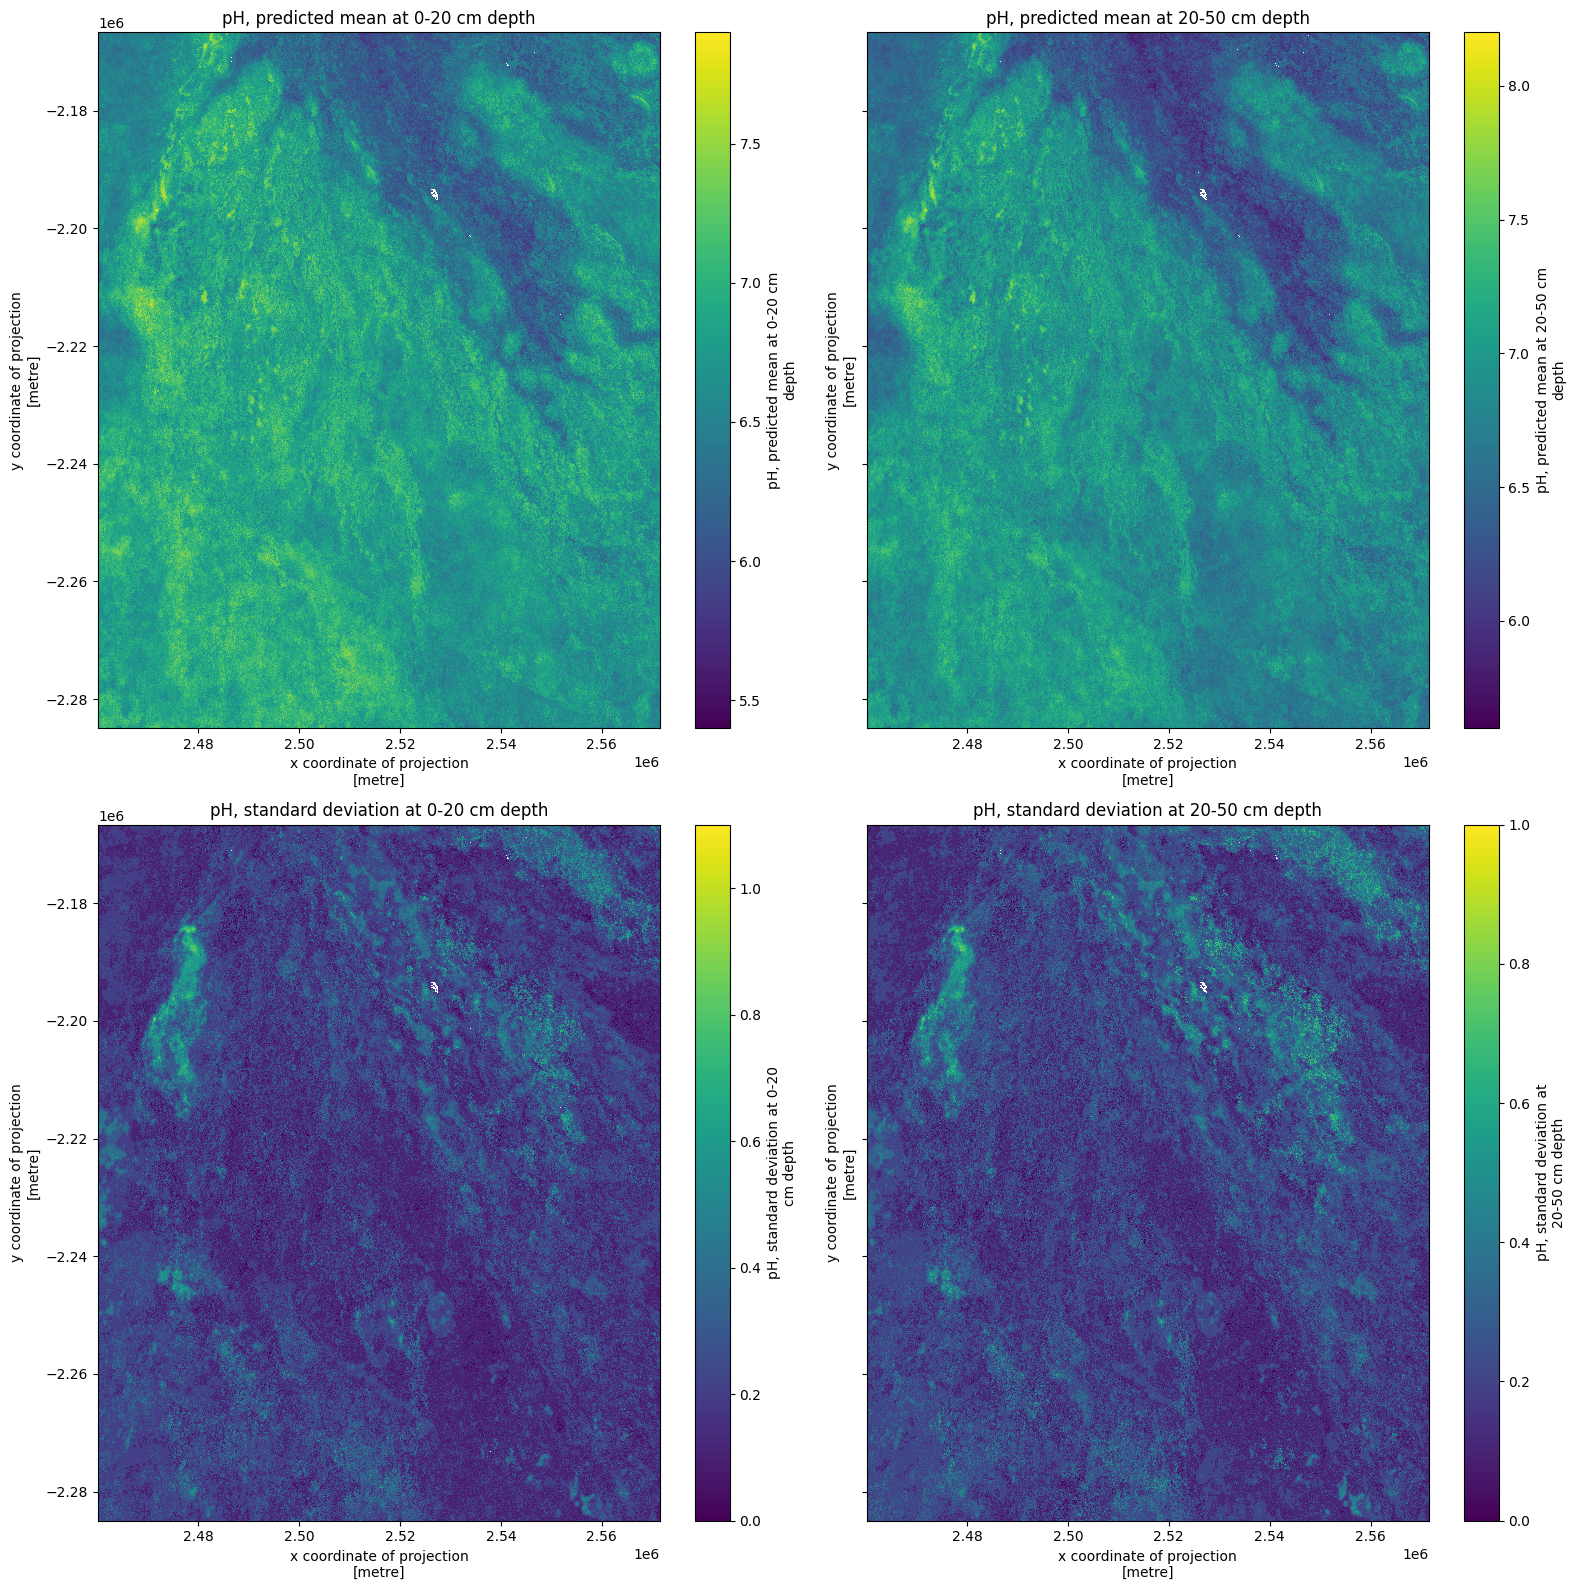

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
ds[list(ds.keys())[0]].plot(ax=ax[0, 0])
ds[list(ds.keys())[1]].plot(ax=ax[0, 1])
ds[list(ds.keys())[2]].plot(ax=ax[1, 0])
ds[list(ds.keys())[3]].plot(ax=ax[1, 1])
ax[0, 0].set_title(list(ds.keys())[0])
ax[0, 1].set_title(list(ds.keys())[1])
ax[1, 0].set_title(list(ds.keys())[2])
ax[1, 1].set_title(list(ds.keys())[3])
plt.tight_layout();

## Conclusions

This notebook gave an introduction into loading [iSDA soil](https://www.isda-africa.com/isdasoil/) data into the Digital Earth Africa sandbox.

Are any patterns observable between the Okavango Delta formation, clay content, and soil pH? How does the Fertility Capability Classification map align with the true colour image?

This notebook is intended to be a starting point. Users may like to try loading data for other areas or other soil variables.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [26]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-02'